In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)

from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import get_tools_output, all_tools
from chat_history import save_chat_history, load_chat_history
from langgraph.checkpoint.memory import MemorySaver

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {
        "data_collector":"data_collector",
        "call_tool": "call_tool", 
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()

def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=20
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    # memory only keep chat history only along agents.
    internal_level_memory = MemorySaver()
    graph = workflow.compile(checkpointer=internal_level_memory)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit, "thread_id":"a"},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER:", "")
    response = response.replace("FINALANSWER,", "")
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

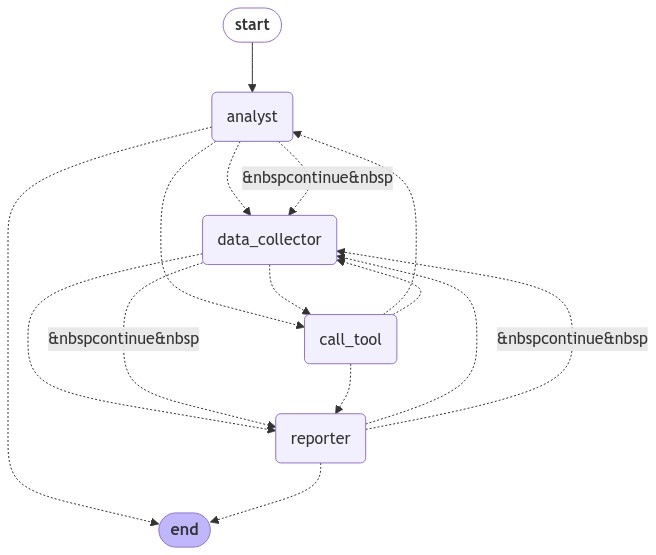

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# import utils
result = submitUserMessage("ค้นหาร้านอาหารใกล้มาบุญครอง พร้อมวิเคราะห์ยอดขาย", keep_chat_history=False, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_6GcEENjdJILmcWJGLHG4Gusz)
 Call ID: call_6GcEENjdJILmcWJGLHG4Gusz
  Args:
    location: มาบุญครอง
  find_place_from_text (call_4ii9dmzYtS7pGLiMa1VeKtxz)
 Call ID: call_4ii9dmzYtS7pGLiMa1VeKtxz
  Args:
    location: มาบุญครอง
================================= Tool Message =================================
Name: find_place_from_text


    address: 444 ถ. พญาไท แขวงวังใหม่ เขตปทุมวัน กรุงเทพมหานคร 10330 ไทย

    location_name: เอ็ม บี เค เซ็นเตอร์

    
================================== Ai Message ==================================
Name: analyst

I have identified the location as "มาบุญครอง" (MBK Center). Now, I will proceed to analyze the sales potential for restaurants in that area. 

Please provide me with the type of restaurant or food category you are interested in analyzing (e.g., Thai food, fast food, etc.), and any specific price point you have i

In [4]:
# submitUserMessage("วิเคราะห์กำไร ขายอาหารใกล้มาบุญครอง ในราคาจานละ 50 บาท ที่ต้นทุน 20 บาทต่อจาน และค่าเช่า 50000 บาทต่อเดือน", keep_chat_history=True, return_reference=True, verbose=True)